In [1]:
%load_ext autoreload

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%autoreload 2
%aimport AD_predictor_tools
%aimport AD_comparison_tools
%aimport PlottingTools

### Does Nicole's screen miss long/short Known ADs?

In [3]:
Stanford_ADs = pd.read_excel("../data/Stanford_Supplementary Table 2 Domains from Tiles.xlsx")
Stanford_ADs

,HGNC symbol,UniProt ID,Domain type,Domain,Start,End,Sequence,Max avg act,Length,Domain overlaps annotation
0,ABRAXAS1,Q6UWZ7,AD,1,121,200,LQEHFSNQDLVFLLLTPSIITESCSTHRLEHSLYKPQKGLFHRVPL...,-1.771253,80,0
1,AHR,P35869,AD,1,531,640,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,1.159695,110,0
2,AHR,P35869,AD,2,641,720,MKHMQVNGMFENWNSNQFVPFNCPQQDPQQYNVFTDLHGISQEFPY...,1.159695,80,0
3,AKAP8,O43823,AD,1,1,80,DQGYGGYGAWSAGPANTQGAYGTGVASWQGYENYNYYGAQNTSVTT...,0.989791,80,0
4,AKAP8L,Q9ULX6,AD,1,1,80,SYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTWNSGTNRGYEGYGY...,0.993831,80,1
...,...,...,...,...,...,...,...,...,...,...
369,ZNF532,Q9HCE3,AD,1,1,80,TMGDMKTPDFDDLLAAFDIPDMVDPKAAIESGHDDHESHMKQNAHG...,0.450331,80,0
370,ZNF592,Q92610,AD,1,1,80,GDMKTPDFDDLLAAFDIPDPTSLDAKEAIQTPSEENESPLKPPGIC...,-0.700514,80,0
371,ZNF644,Q9H582,AD,1,901,980,PGENATLSYDQNDGFYFEYYEDTGSNNFLHEIHDPQHLETADASLS...,-1.303710,80,0
372,ZNF687,Q8N1G0,AD,1,1,80,GDMKTPDFDDLLAAFDIPDIDANEAIHSGPEENEGPGGPGKPEPGV...,0.381333,80,0


In [4]:
CRTF =  pd.read_excel("../data/DelRosso_2023_supp_table_1", sheet_name = "CRTF Proteins Summary")
CRTF

,HGNC Symbol,Contains minCMV AD?,Contains pEF RD?,Contains PGK RD?
0,A1CF,0,1,0
1,ABRAXAS1,1,1,1
2,ABRAXAS2,0,0,1
3,AC008770.3,0,1,1
4,AC023509.3,0,0,0
...,...,...,...,...
2042,ZUFSP,0,0,1
2043,ZXDA,0,0,0
2044,ZXDB,0,0,0
2045,ZXDC,0,1,0


In [5]:
# Compiling list of known ADs (without merging)

# Loading in all known effector domains
# GSL, activity data, Soto ED list, Nicole hits

#GSL
GSL = pd.read_csv("../data/GSL.csv")[["GeneName", "Start", "End", "uniprotID", "Reference"]]
GSL["Reference"] = GSL["Reference"] + ", GSL"

# Active predictions
activity_data = pd.read_csv('../data/Staller2021/SupplementalDataSet4_ActivityData_PredictedADs_renorm20210708_uniprotIDs_added.csv', index_col = 0)
activity_data = activity_data[activity_data["RegionType"] == "Prediction"]
active = activity_data[activity_data["Activity_mean"] > 221]
active["Reference"] = "Staller Activity Data"
active = active[["GeneName", "Start", "End", "uniprotID", "Reference"]]
active["GeneName"] = active["GeneName"].str.extract(r'\|.*\|(.*)_')

# Downloading Soto effector domain list (not just activation domains)
# From: https://pubmed.ncbi.nlm.nih.gov/34863368/
Soto = pd.read_csv("../data/SotoEtAl_ADs.csv")
#Soto = Soto.rename(columns = {"Uniprot ID" : "uniprotID"})
Soto["GeneName"] = ""
Soto["Reference"] = "PMID: " + Soto["Reference (PMID)"] + ", Soto " + Soto["Domain type"]
#Soto["Start"] = Soto["Coordinates"].str.split("-").str[0]
#Soto["End"] = Soto["Coordinates"].str.split("-").str[1]
Soto = Soto[["GeneName", "Start", "End", "uniprotID", "Reference"]]

known_ADs_unmerged = pd.concat([GSL, Soto, active])
# known_ADs_unmerged = pd.concat([GSL, Soto])
known_ADs_unmerged

,GeneName,Start,End,uniprotID,Reference
0,OTX2,231.0,289.0,P32243,"uniprot, GSL"
1,CRX,200.0,284.0,O43186,"Chen 2002 pg 873, GSL"
2,VP16,411.0,490.0,P06492,"nan / nan / nan / nan, GSL"
3,Oct-4,1.0,137.0,Q01860,"Brehm, GSL"
4,Oct-4,290.0,360.0,Q01860,"Boija 2018, GSL"
...,...,...,...,...,...
143,ETV1,36.0,83.0,P50549,Staller Activity Data
145,E2F4,366.0,407.0,Q16254,Staller Activity Data
146,NCOA2,785.0,825.0,Q15596,Staller Activity Data
147,NCOA2,1058.0,1097.0,Q15596,Staller Activity Data


In [6]:
# Reading in the primary gene names, from uniprot using the uniprot IDs
known_AD_gene_names = pd.read_csv("../data/known_ED_gene_names.tsv", sep = "\t")
known_AD_gene_names = known_AD_gene_names.rename(columns = {"From" : "uniprotID",
                                         "Gene Names (primary)" : "gene-symbol"})
known_AD_gene_names = known_AD_gene_names.drop(columns = "Entry")
known_ADs_unmerged = pd.merge(known_ADs_unmerged, known_AD_gene_names, on = "uniprotID", how = "left")
known_ADs_unmerged

,GeneName,Start,End,uniprotID,Reference,gene-symbol
0,OTX2,231.0,289.0,P32243,"uniprot, GSL",OTX2
1,CRX,200.0,284.0,O43186,"Chen 2002 pg 873, GSL",CRX
2,VP16,411.0,490.0,P06492,"nan / nan / nan / nan, GSL",NaN
3,Oct-4,1.0,137.0,Q01860,"Brehm, GSL",POU5F1
4,Oct-4,290.0,360.0,Q01860,"Boija 2018, GSL",POU5F1
...,...,...,...,...,...,...
740,ETV1,36.0,83.0,P50549,Staller Activity Data,ETV1
741,E2F4,366.0,407.0,Q16254,Staller Activity Data,E2F4
742,NCOA2,785.0,825.0,Q15596,Staller Activity Data,NCOA2
743,NCOA2,1058.0,1097.0,Q15596,Staller Activity Data,NCOA2


In [7]:
tested_known_AD_TFs = known_ADs_unmerged[known_ADs_unmerged["gene-symbol"].isin(CRTF["HGNC Symbol"])]
tested_known_AD_TFs["Start"] = tested_known_AD_TFs["Start"].astype(int)
tested_known_AD_TFs["End"] = tested_known_AD_TFs["End"].astype(int)
tested_known_AD_TFs

,GeneName,Start,End,uniprotID,Reference,gene-symbol
0,OTX2,231,289,P32243,"uniprot, GSL",OTX2
1,CRX,200,284,O43186,"Chen 2002 pg 873, GSL",CRX
3,Oct-4,1,137,Q01860,"Brehm, GSL",POU5F1
4,Oct-4,290,360,Q01860,"Boija 2018, GSL",POU5F1
5,Oct-2,95,136,P09086,"Choi 2000 list, GSL",POU2F2
...,...,...,...,...,...,...
740,ETV1,36,83,P50549,Staller Activity Data,ETV1
741,E2F4,366,407,Q16254,Staller Activity Data,E2F4
742,NCOA2,785,825,Q15596,Staller Activity Data,NCOA2
743,NCOA2,1058,1097,Q15596,Staller Activity Data,NCOA2


In [8]:
Stanford_ADs = pd.read_excel("../data/Stanford_Supplementary Table 2 Domains from Tiles.xlsx")
Stanford_ADs = Stanford_ADs.rename(columns = {"UniProt ID": "uniprotID"})
Stanford_ADs["Start"] = Stanford_ADs["Start"].astype(int)
Stanford_ADs["End"] = Stanford_ADs["End"].astype(int)

In [9]:
AD_comparison_tools.add_col_contains_prediction(tested_known_AD_TFs, Stanford_ADs, 
                                                ID_col_name="uniprotID", 
                                                start_col_name="Start", 
                                                end_col_name="End", 
                                                result_col_name="Stanford")

In [10]:
tested_known_AD_TFs["Length"] = tested_known_AD_TFs["End"] - tested_known_AD_TFs["Start"] + 1
tested_known_AD_TFs

,GeneName,Start,End,uniprotID,Reference,gene-symbol,Stanford,Length
0,OTX2,231,289,P32243,"uniprot, GSL",OTX2,False,59
1,CRX,200,284,O43186,"Chen 2002 pg 873, GSL",CRX,True,85
3,Oct-4,1,137,Q01860,"Brehm, GSL",POU5F1,True,137
4,Oct-4,290,360,Q01860,"Boija 2018, GSL",POU5F1,False,71
5,Oct-2,95,136,P09086,"Choi 2000 list, GSL",POU2F2,False,42
...,...,...,...,...,...,...,...,...
740,ETV1,36,83,P50549,Staller Activity Data,ETV1,True,48
741,E2F4,366,407,Q16254,Staller Activity Data,E2F4,True,42
742,NCOA2,785,825,Q15596,Staller Activity Data,NCOA2,False,41
743,NCOA2,1058,1097,Q15596,Staller Activity Data,NCOA2,True,40


In [11]:
false_negatives = tested_known_AD_TFs[~tested_known_AD_TFs["Stanford"]]
true_positives = tested_known_AD_TFs[tested_known_AD_TFs["Stanford"]]

In [12]:
len(false_negatives)

511

In [13]:
len(true_positives)

217

In [14]:
AD_comparison_tools.add_col_contains_prediction(Stanford_ADs, tested_known_AD_TFs, 
                                                ID_col_name="uniprotID", 
                                                start_col_name="Start", 
                                                end_col_name="End", 
                                                result_col_name="known")

In [15]:
sum(Stanford_ADs["known"]) 

161

In [16]:
len(Stanford_ADs)

374

In [17]:
sum(Stanford_ADs["known"]) / len(Stanford_ADs)

0.4304812834224599

In [18]:
# 161 out of 374 Stanford ADs have previously been identified, or about 43%

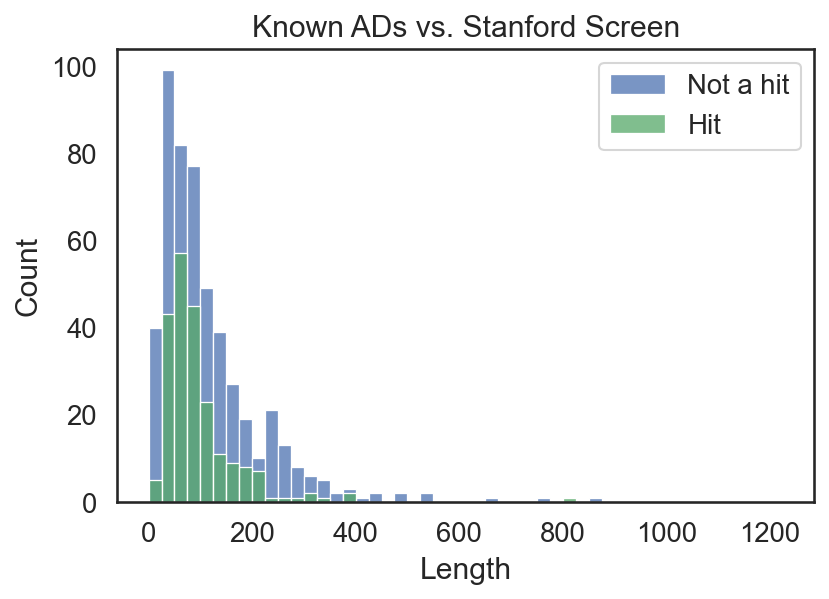

In [19]:
plt.figure(figsize=(6, 4), dpi = 150)
bins = np.arange(0, max(max(true_positives["Length"]), max(false_negatives["Length"])) + 1, 25)
sns.histplot(false_negatives["Length"], color = "b", label = "Not a hit", bins = bins)
sns.histplot(true_positives["Length"], color = "g", label = "Hit", bins = bins)
plt.title("Known ADs vs. Stanford Screen")
plt.legend();

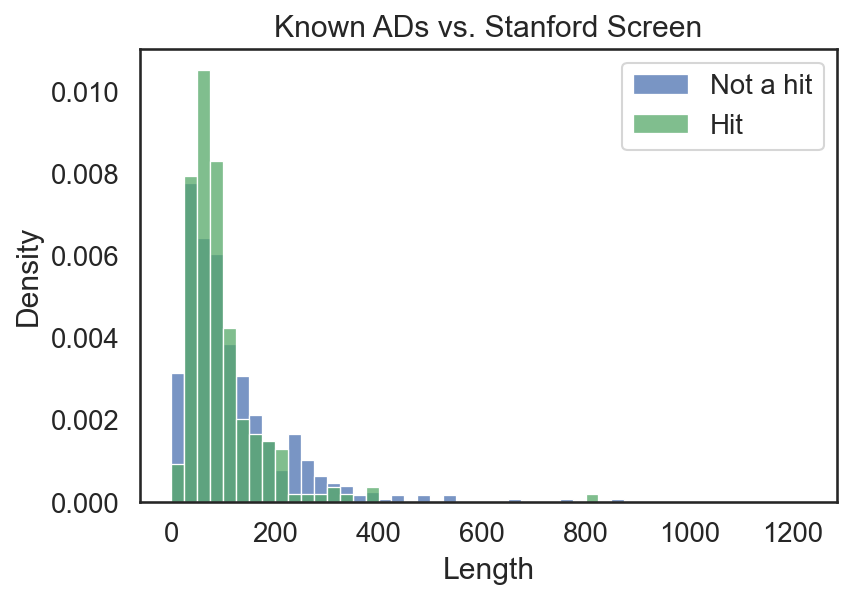

In [20]:
plt.figure(figsize=(6, 4), dpi = 150)
bins = np.arange(0, max(max(true_positives["Length"]), max(false_negatives["Length"])) + 1, 25)
sns.histplot(false_negatives["Length"], color = "b", label = "Not a hit", stat = "density", bins = bins)
sns.histplot(true_positives["Length"], color = "g", label = "Hit", stat = "density", bins = bins)
plt.title("Known ADs vs. Stanford Screen")
plt.legend();

In [21]:
tested_known_AD_TFs["Stanford"] = tested_known_AD_TFs["Stanford"].replace({False: "Not a hit",
                                                                          True: "Hit"})

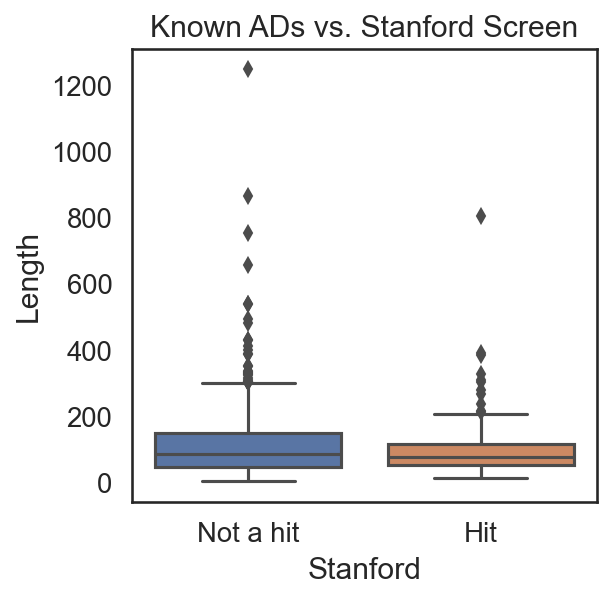

In [22]:
plt.figure(figsize=(4, 4), dpi = 150)
sns.boxplot(data = tested_known_AD_TFs, x = "Stanford", y = "Length")
plt.title("Known ADs vs. Stanford Screen");

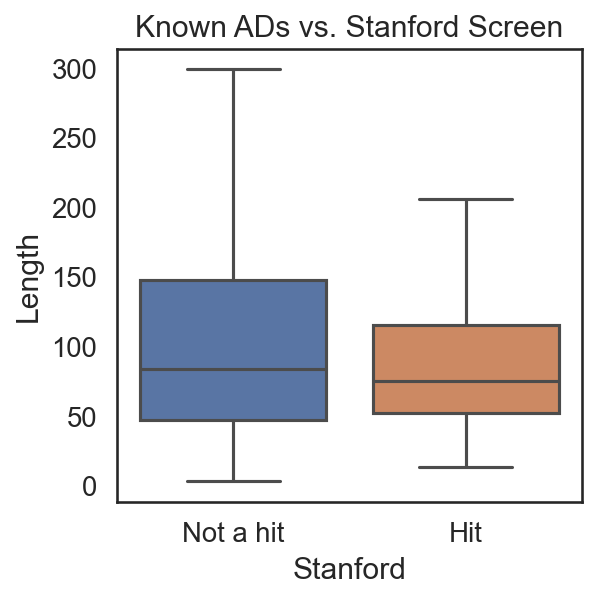

In [23]:
plt.figure(figsize=(4, 4), dpi = 150)
sns.boxplot(data = tested_known_AD_TFs, x = "Stanford", y = "Length", showfliers=False)
plt.title("Known ADs vs. Stanford Screen");

## Histogram only with known ADs with length <= 80

In [24]:
fn_80 = false_negatives[false_negatives["Length"] <= 80]
fn_80

,GeneName,Start,End,uniprotID,Reference,gene-symbol,Stanford,Length
0,OTX2,231,289,P32243,"uniprot, GSL",OTX2,False,59
4,Oct-4,290,360,Q01860,"Boija 2018, GSL",POU5F1,False,71
5,Oct-2,95,136,P09086,"Choi 2000 list, GSL",POU2F2,False,42
6,Oct-2,422,463,P09086,"Choi 2000 list, GSL",POU2F2,False,42
7,STAT1,710,750,P42224,"Wojciak, J., Martinez-Yamout, M., Dyson, H., W...",STAT1,False,41
...,...,...,...,...,...,...,...,...
726,ZFHX4,1404,1443,Q86UP3,Staller Activity Data,ZFHX4,False,40
727,HIF1A,533,572,Q16665,Staller Activity Data,HIF1A,False,40
731,ZBT44,508,553,Q8NCP5,Staller Activity Data,ZBTB44,False,46
736,VDR,195,236,P11473,Staller Activity Data,VDR,False,42


In [25]:
tp_80 = true_positives[true_positives["Length"] <= 80]
tp_80

,GeneName,Start,End,uniprotID,Reference,gene-symbol,Stanford,Length
12,TP53 / p53,1,61,P04637,"nan / activation_regions.txt / nan, GSL",TP53,True,61
14,ETV4/PEA3,43,84,P43268,"Henley et al, GSL",ETV4,True,42
15,ETV5/ETV/PEA3/ERM,38,68,P41161,"Henley et al, GSL",ETV5,True,31
16,ETV1/ER81,38,69,P50549,"Henley et al, GSL",ETV1,True,32
23,MYB / c-Myb,275,327,P10242,"nan / nan / activation_regions.txt, GSL",MYB,True,53
...,...,...,...,...,...,...,...,...
738,CREB3,1,55,O43889,Staller Activity Data,CREB3,True,55
740,ETV1,36,83,P50549,Staller Activity Data,ETV1,True,48
741,E2F4,366,407,Q16254,Staller Activity Data,E2F4,True,42
743,NCOA2,1058,1097,Q15596,Staller Activity Data,NCOA2,True,40


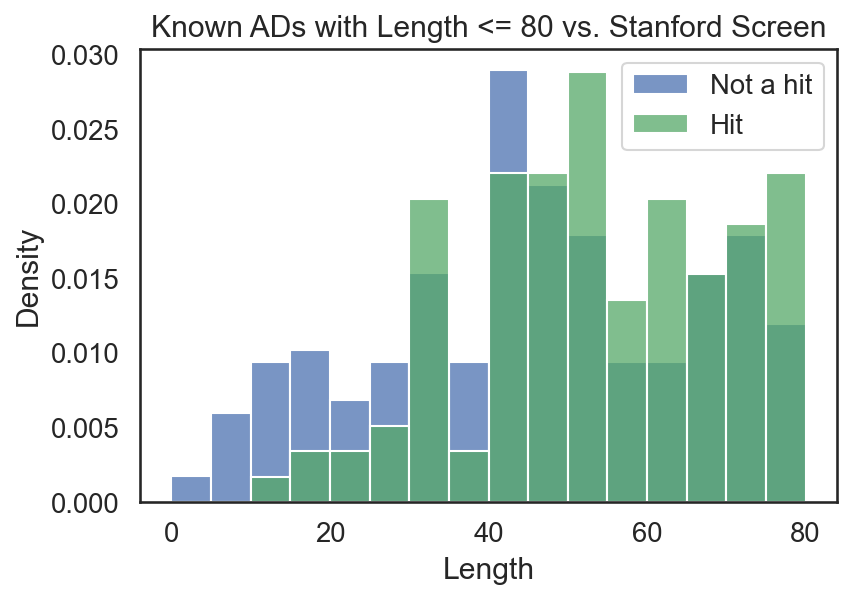

In [26]:
plt.figure(figsize=(6, 4), dpi = 150)
bins = np.arange(0, max(max(tp_80["Length"]), max(fn_80["Length"])) + 1, 5)
sns.histplot(fn_80["Length"], color = "b", label = "Not a hit", stat = "density", bins = bins)
sns.histplot(tp_80["Length"], color = "g", label = "Hit", stat = "density", bins = bins)
plt.title("Known ADs with Length <= 80 vs. Stanford Screen")
plt.legend();

What's blue in histogram above, on SFARI list, and has length =<80?

In [27]:
fn_80

,GeneName,Start,End,uniprotID,Reference,gene-symbol,Stanford,Length
0,OTX2,231,289,P32243,"uniprot, GSL",OTX2,False,59
4,Oct-4,290,360,Q01860,"Boija 2018, GSL",POU5F1,False,71
5,Oct-2,95,136,P09086,"Choi 2000 list, GSL",POU2F2,False,42
6,Oct-2,422,463,P09086,"Choi 2000 list, GSL",POU2F2,False,42
7,STAT1,710,750,P42224,"Wojciak, J., Martinez-Yamout, M., Dyson, H., W...",STAT1,False,41
...,...,...,...,...,...,...,...,...
726,ZFHX4,1404,1443,Q86UP3,Staller Activity Data,ZFHX4,False,40
727,HIF1A,533,572,Q16665,Staller Activity Data,HIF1A,False,40
731,ZBT44,508,553,Q8NCP5,Staller Activity Data,ZBTB44,False,46
736,VDR,195,236,P11473,Staller Activity Data,VDR,False,42


In [28]:
sfari_tfs = pd.read_csv("../data/SFARI_TFs.csv")
sfari_tfs

,Unnamed: 0,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,eagle,number-of-reports,GeneName,ProteinSeq,uniprotID
0,0,9,ADNP,Activity-dependent neuroprotector homeobox,ENSG00000101126,20,"Rare Single Gene Mutation, Syndromic, Functional",1.0,1,41.50,64,sp|Q9H2P0|ADNP_HUMAN,MFQLPVNNLGSLRKARKTVKKILSDIGLEYCKEHIEDFKQFEPNDF...,Q9H2P0
1,1,9,AHDC1,AT-hook DNA binding motif containing 1,ENSG00000126705,1,"Rare Single Gene Mutation, Syndromic",1.0,1,14.25,24,sp|Q5TGY3|AHDC1_HUMAN,MRVKPQGLVVTSSAVCSSPDYLREPKYYPGGPPTPRPLLPTRPPAS...,Q5TGY3
2,2,9,ARID2,AT-rich interaction domain 2,ENSG00000189079,12,"Rare Single Gene Mutation, Syndromic",2.0,1,NaN,12,sp|Q68CP9|ARID2_HUMAN,MANSTGKAPPDERRKGLAFLDELRQFHHSRGSPFKKIPAVGGKELD...,Q68CP9
3,3,9,ARNT2,aryl-hydrocarbon receptor nuclear translocator 2,ENSG00000172379,15,"Rare Single Gene Mutation, Syndromic, Genetic ...",2.0,0,NaN,15,sp|Q9HBZ2|ARNT2_HUMAN,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,Q9HBZ2
4,4,9,ARX,aristaless related homeobox,ENSG00000004848,X,"Rare Single Gene Mutation, Syndromic",1.0,1,13.80,24,sp|Q96QS3|ARX_HUMAN,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,Q96QS3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,122,9,ZNF711,zinc finger protein 711,ENSG00000147180,X,Rare Single Gene Mutation,2.0,0,NaN,5,sp|Q9Y462|ZN711_HUMAN,MDSGGGSLGLHTPDSRMAHTMIMQDFVAGMAGTAHIDGDHIVVSVP...,Q9Y462
123,123,9,ZNF713,Zinc finger protein 713,ENSG00000178665,7,Rare Single Gene Mutation,2.0,0,NaN,3,sp|Q8N859|ZN713_HUMAN,MEEEEMNDGSQMVRSQESLTFQDVAVDFTREEWDQLYPAQKNLYRD...,Q8N859
124,124,9,ZNF774,Zinc finger protein 774,ENSG00000196391,15,Rare Single Gene Mutation,2.0,0,NaN,4,sp|Q6NX45|ZN774_HUMAN,MWLGTSGKSGLPGHCLENPLQECHPAQLEEWALKGISRPSVISQPE...,Q6NX45
125,125,9,ZNF804A,Zinc finger protein 804A,ENSG00000170396,2,"Rare Single Gene Mutation, Genetic Association...",2.0,0,NaN,16,sp|Q7Z570|Z804A_HUMAN,MECYYIVISSTHLSNGHFRNIKGVFRGPLSKNGNKTLDYAEKENTI...,Q7Z570


In [29]:
fn_80[fn_80["uniprotID"].isin(sfari_tfs["uniprotID"])]

,GeneName,Start,End,uniprotID,Reference,gene-symbol,Stanford,Length
21,VDR,195,238,P11473,"Choi 2000 list OR uniprot. check, GSL",VDR,False,44
42,PAX5,304,358,Q02548,"Choi 2000 list, GSL",PAX5,False,55
74,SMAD4,275,322,Q13485,"Choi 2000 list, GSL",SMAD4,False,48
119,YY1,371,397,P25490,"activation_regions.txt, GSL",YY1,False,27
159,TCF7L2,459,505,Q9NQB0,"activation_regions.txt, GSL",TCF7L2,False,47
240,,440,486,P11308,"PMID: 9681824, Soto AD",ERG,False,47
369,,209,252,Q9BXK1,"PMID: 22203677, Soto AD",KLF16,False,44
400,,234,267,P35548,"PMID: 19338779, Soto AD",MSX2,False,34
459,,220,273,O95096,"PMID: 10944215, Soto AD",NKX2-2,False,54
480,,584,598,P43354,"PMID: 9572393, Soto AD",NR4A2,False,15


In [30]:
sfari_tfs[sfari_tfs["uniprotID"].isin(fn_80["uniprotID"])]

,Unnamed: 0,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,gene-score,syndromic,eagle,number-of-reports,GeneName,ProteinSeq,uniprotID
10,10,9,CC2D1A,Coiled-coil and C2 domain containing 1A,ENSG00000132024,19,"Rare Single Gene Mutation, Functional",2.0,0,NaN,15,sp|Q6P1N0|C2D1A_HUMAN,MHKRKGPPGPPGRGAAAARQLGLLVDLSPDGLMIPEDGANDEELEA...,Q6P1N0
31,31,9,ERG,"ERG, ETS transcription factor",ENSG00000157554,21,Genetic Association,2.0,0,NaN,1,sp|P11308|ERG_HUMAN,MIQTVPDPAAHIKEALSVVSEDQSLFECAYGTPHLAKTEMTASSSS...,P11308
39,39,9,KLF16,Kruppel like factor 16,ENSG00000129911,19,Rare Single Gene Mutation,2.0,0,NaN,1,sp|Q9BXK1|KLF16_HUMAN,MSAAVACVDYFAADVLMAISSGAVVHRGRPGPEGAGPAAGLDVRAA...,Q9BXK1
52,52,9,MSX2,msh homeobox 2,ENSG00000120149,5,"Rare Single Gene Mutation, Syndromic",3.0,1,NaN,2,sp|P35548|MSX2_HUMAN,MASPSKGNDLFSPDEEGPAVVAGPGPGPGGAEGAAEERRVKVSSLP...,P35548
64,64,9,NR4A2,nuclear receptor subfamily 4 group A member 2,ENSG00000153234,2,"Rare Single Gene Mutation, Syndromic",1.0,0,7.75,10,sp|P43354|NR4A2_HUMAN,MPCVQAQYGSSPQGASPASQSYSYHSSGEYSSDFLTPEFVKFSMDL...,P43354
65,65,9,NKX2-2,NK2 homeobox 2,ENSG00000125820,20,"Genetic Association, Functional",3.0,0,NaN,2,sp|O95096|NKX22_HUMAN,MSLTNTKTGFSVKDILDLPDTNDEEGSVAEGPEEENEGPEPAKRAG...,O95096
68,68,9,PAX5,Paired box 5,ENSG00000196092,9,Rare Single Gene Mutation,1.0,0,5.75,10,sp|Q02548|PAX5_HUMAN,MDLEKNYPTPRTSRTGHGGVNQLGGVFVNGRPLPDVVRQRIVELAH...,Q02548
72,72,9,PITX1,paired-like homeodomain 1,ENSG00000069011,5,"Rare Single Gene Mutation, Genetic Association",2.0,0,NaN,6,sp|P78337|PITX1_HUMAN,MDAFKGGMSLERLPEGLRPPPPPPHDMGPAFHLARPADPREPLENS...,P78337
88,88,9,SMAD4,SMAD family member 4,ENSG00000141646,18,Rare Single Gene Mutation,2.0,0,NaN,8,sp|Q13485|SMAD4_HUMAN,MDNMSITNTPTSNDACLSIVHSLMCHRQGGESETFAKRAIESLVKK...,Q13485
98,98,9,TCF4,Transcription factor 4,ENSG00000196628,18,"Rare Single Gene Mutation, Syndromic, Genetic ...",1.0,1,13.50,62,sp|P15884|ITF2_HUMAN,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFT...,P15884


In [31]:
for symbol in sfari_tfs[sfari_tfs["uniprotID"].isin(fn_80["uniprotID"])]["gene-symbol"]:
    print(symbol)

CC2D1A
ERG
KLF16
MSX2
NR4A2
NKX2-2
PAX5
PITX1
SMAD4
TCF4
TCF7L2
THRA
YY1
VDR


In [32]:
len(sfari_tfs[sfari_tfs["uniprotID"].isin(fn_80["uniprotID"])])

14

In [35]:
fn_80.to_csv("../data/Stanford_at_or_under80_false_negatives.csv")